# Airlines Tweet Analysis with Word Embeddings

First download dataset with commandiin data folder `data/`
`cd data && kaggle datasets download -d crowdflower/twitter-airline-sentiment` and 
unzip with `unzip twitter-airline-sentiment.zip -d twitter-airline-sentiment`.

In this notebook we compare different embeddings and how they affect model performance (accuracy and convergence).

We compare
1. Baseline - No embeddings, simply tokenize and build a vocab using Torchtext.Vocab and train.
2. Airline - Use a Word2Vec (100d) trained on the airline dataset to see performance as default embeddings
3. Text8 - Use a Word2Wec (100d) trained on the text8 dataset 
4. GoogleNewsVectors - Use the pretrained googlenewsvectors (300d) embeddings

Todo.
In future projects, perhaps compare other factors.
1. Model design (LSTM, RNN, Linear Regression)
2. 

## Torchtext.Vocab
Let's first use a torchtext.vocab to build our vocabulary and train a embedding from scratch.

In [52]:
import os
import re
import numpy as np
from tqdm import tqdm
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pandas.core.series import Series
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
from torchtext.data import get_tokenizer
from torchtext.vocab import Vocab
from torchtext.vocab import vocab
from torchtext.transforms import PadTransform
import torch.optim as optim
import torch.nn.functional as F

from collections import Counter, OrderedDict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')

from gensim.models import Word2Vec, KeyedVectors

[nltk_data] Downloading package stopwords to /home/ltq/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ltq/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ltq/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [53]:
# Helper functions
def plot_history(history):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    

In [54]:
df = pd.read_csv('../data/twitter-airline-sentiment/Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [55]:
def clean_text(d):
    pattern = r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', d)
    return text

def clean_stopword(d):
    stop_words = stopwords.words('english')
    names = airline_names = ['delta', 'deltaair', 'united', 'unitedair', 'southwest', 'southwestair', 'usairways','virginamerica', 'american', 'americanair', 'jetblue', 'jetblues', 'usairway', 'flight', 'airline', 'airlines']
    for name in names:
        stop_words.append(name)
    return " ".join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 1])

def tokenize(d):
    return word_tokenize(d)

df['final_text']= df.text.apply(clean_text).apply(clean_stopword).apply(tokenize)
df.final_text.head()

0                                     [dhepburn, said]
1    [plus, youve, added, commercials, experience, ...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: final_text, dtype: object

In [56]:
# VADER Sentiment Analysis
vader = SentimentIntensityAnalyzer()
example = 0
example_text = " ".join(df.final_text[example])
print("Original Text:", df.text[example])
print("Cleaned Text:", example_text)
print("Airline Classification:", df.airline_sentiment[example])
print("Vader Classification:", vader.polarity_scores(example_text))

Original Text: @VirginAmerica What @dhepburn said.
Cleaned Text: dhepburn said
Airline Classification: neutral
Vader Classification: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [57]:
# Combine final_text into scentences
df.final_text = df.final_text.apply(lambda x: " ".join(x))
df.final_text[0]

'dhepburn said'

In [58]:
# Convert sentiment into numerical, positive = 2, neutral = 1, negative =0
df.airline_sentiment = df.airline_sentiment.apply(lambda x: 2 if x == 'positive' else 1 if x == 'neutral' else 0)

In [59]:
# Features and target
X = df.final_text
y = df.airline_sentiment

In [60]:
# Word2Vec
texts_w2v = df.final_text.apply(tokenize).to_list()
w2v = Word2Vec(sentences = texts_w2v, window = 5, vector_size = 100, min_count = 5, workers = 4)
w2v.save('../out/airlinetweets_word2vec_100.model')

print(texts_w2v[:3])
print(w2v.wv.most_similar('good'))

[['dhepburn', 'said'], ['plus', 'youve', 'added', 'commercials', 'experience', 'tacky'], ['didnt', 'today', 'must', 'mean', 'need', 'take', 'another', 'trip']]
[('sure', 0.9987474679946899), ('helpful', 0.9987229108810425), ('anything', 0.998719334602356), ('better', 0.9986938834190369), ('nice', 0.9986199736595154), ('feel', 0.9986160397529602), ('tweet', 0.9985759854316711), ('appreciate', 0.9985724091529846), ('right', 0.9985563158988953), ('aa', 0.9985223412513733)]


In [61]:
def tokenize_pad_sequences(text: Series, max_len, max_words):
    # Create vocabulary and tokenizer
    tokenizer = get_tokenizer("basic_english")
    counter = Counter()
    for t in text:
        counter.update(tokenizer(t))
    
    # Build vocab
    most_common_tokens = counter.most_common(max_words - 2)
    # limited_counter = Counter(dict(most_common_tokens))
    limited_counter = OrderedDict(most_common_tokens)
    my_vocab = vocab(limited_counter)
    my_vocab.insert_token("<unk>", 0)  # Insert unk at position 0
    my_vocab.insert_token("<pad>", len(my_vocab))  # Insert pad at the end
    my_vocab.set_default_index(my_vocab['<unk>']) 
  

    # Transform the text into sequences
    text_transform = lambda x: [my_vocab[token] for token in tokenizer(x)]
    X = [text_transform(t) for t in text]
    X = [torch.tensor(x) for x in X]
    
    # Pad the sequences
    pad_transform = PadTransform(max_length=max_len, pad_value=my_vocab['<pad>'])
    X = [pad_transform(x) for x in X]
    return X, my_vocab
    
print(type(df['text']))
print('Before Tokenization & Padding: \n', df['text'][0],'\n')
X, my_vocab = tokenize_pad_sequences(df['text'], 100, 5000)
print('After Tokenization & Padding: \n', X[0].shape, X[0])

<class 'pandas.core.series.Series'>
Before Tokenization & Padding: 
 @VirginAmerica What @dhepburn said. 

After Tokenization & Padding: 
 torch.Size([100]) tensor([  90,   56,    0,  228,    1, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999, 4999,
        4999, 4999, 4999, 4999])


In [62]:
# Training Data
y = pd.get_dummies(df['airline_sentiment'])
X_train, X_test = X[:int(len(X)*0.8)], X[int(len(X)*0.8):]
X_train, X_test = torch.stack(X_train), torch.stack(X_test)
y_train, y_test = y[:int(len(y)*0.8)], y[int(len(y)*0.8):]
y_train, y_test = torch.tensor(y_train.values), torch.tensor(y_test.values)

# Shapes
print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)


Train torch.Size([11712, 100]) torch.Size([11712, 3])
Test torch.Size([2928, 100]) torch.Size([2928, 3])


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [64]:
class SentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout, pretrained_embeddings=None):
        super(SentimentModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        if pretrained_embeddings is not None:
            self.embedding.weight.data.copy_(pretrained_embeddings)
            self.embedding.weight.requires_grad = True # Freeze embeddings if set to False
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden.squeeze(0))
    
def accuracy(output, target):
    """
    Get accuracy of the model when output is [batch_size, n_classes] and target is [batch_size, n_classes]
    """
    return (torch.argmax(output, dim=1) == torch.argmax(target, dim=1)).sum().item() / len(target)
    
# Training and Evaluation functions
def train_step(model, iterator, optimizer, criterion, device):
    epoch_loss, epoch_acc = 0, 0
    model.train()
    for x, y in iterator:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred, y)
        acc = accuracy(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

def eval_step(model, iterator, criterion, device):
    epoch_loss, epoch_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in iterator:
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            acc = accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc
            
    return epoch_loss/len(iterator), epoch_acc/len(iterator)

all_history = {}

torch.Size([11712, 100]) torch.Size([11712, 3])
torch.Size([2928, 100]) torch.Size([2928, 3])
X_train type: torch.int64
X_test type: torch.int64
y_train type: torch.uint8
y_test type: torch.uint8
Max index in X_train: 4999
Max index in X_test: 4999
SentimentModel(
  (embedding): Embedding(5000, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:07,  1.21it/s]

Epoch 1/10
Train Loss 0.8824930031442902, Train Acc 0.6239754098360656
Val Loss 0.6893355081910673, Val Acc 0.759171195652174
--------------------------------------------------


 20%|██        | 2/10 [00:01<00:06,  1.22it/s]

Epoch 2/10
Train Loss 0.6907909509262752, Train Acc 0.725068306010929
Val Loss 0.5961506301942079, Val Acc 0.7494338768115942
--------------------------------------------------


 30%|███       | 3/10 [00:02<00:05,  1.20it/s]

Epoch 3/10
Train Loss 0.5673002628355078, Train Acc 0.7841530054644809
Val Loss 0.5148037037123805, Val Acc 0.7956295289855073
--------------------------------------------------


 40%|████      | 4/10 [00:03<00:04,  1.21it/s]

Epoch 4/10
Train Loss 0.49556767468244, Train Acc 0.8154030054644809
Val Loss 0.5369177195041076, Val Acc 0.7804574275362318
--------------------------------------------------


 50%|█████     | 5/10 [00:04<00:04,  1.22it/s]

Epoch 5/10
Train Loss 0.43224346739509717, Train Acc 0.8434084699453552
Val Loss 0.5522883547388989, Val Acc 0.7728713768115942
--------------------------------------------------


 60%|██████    | 6/10 [00:04<00:03,  1.22it/s]

Epoch 6/10
Train Loss 0.3818131662864503, Train Acc 0.8672301912568307
Val Loss 0.5516632354777792, Val Acc 0.782608695652174
--------------------------------------------------


 70%|███████   | 7/10 [00:05<00:02,  1.22it/s]

Epoch 7/10
Train Loss 0.3338026564792206, Train Acc 0.8837943989071039
Val Loss 0.5760706021733906, Val Acc 0.7783061594202899
--------------------------------------------------


 80%|████████  | 8/10 [00:06<00:01,  1.22it/s]

Epoch 8/10
Train Loss 0.30490964462807596, Train Acc 0.898650956284153
Val Loss 0.5981042566506759, Val Acc 0.7803442028985508
--------------------------------------------------


 90%|█████████ | 9/10 [00:07<00:00,  1.21it/s]

Epoch 9/10
Train Loss 0.26244429986455725, Train Acc 0.9144467213114754
Val Loss 0.630406379699707, Val Acc 0.7668704710144927
--------------------------------------------------


100%|██████████| 10/10 [00:08<00:00,  1.22it/s]

Epoch 10/10
Train Loss 0.2345095696792902, Train Acc 0.9276810109289617
Val Loss 0.6510882280443026, Val Acc 0.770606884057971
--------------------------------------------------


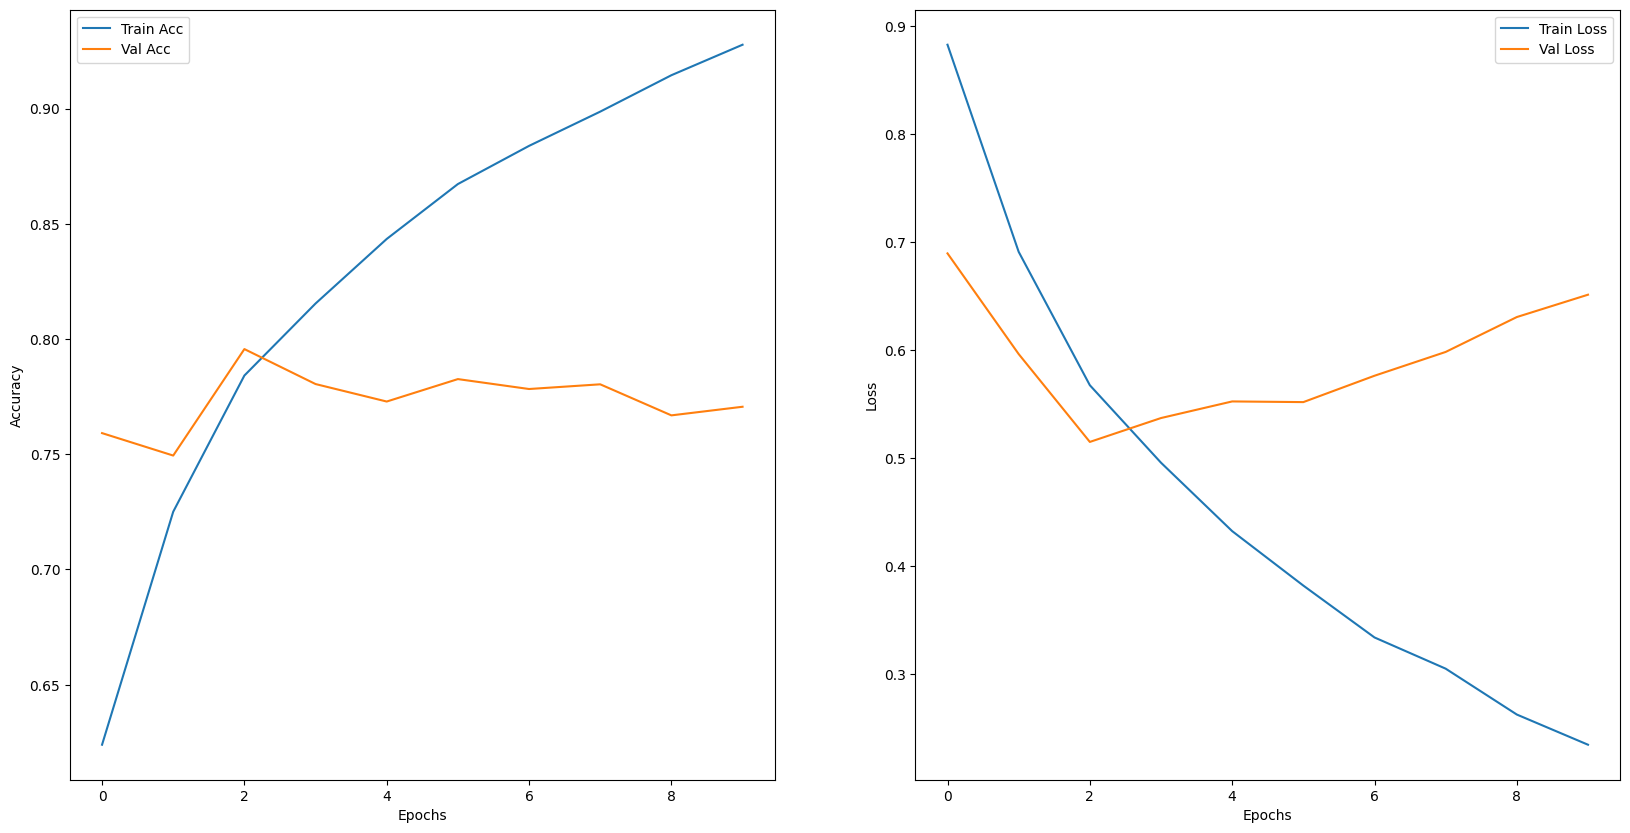

In [65]:
# Train the model
print(X_train.shape, y_train.shape) # torch.Size([11712, 100]) torch.Size([11712, 3])
print(X_test.shape, y_test.shape) # torch.Size([2928, 100]) torch.Size([2928, 3])

# Type conversion to torch.long
print("X_train type:", X_train.dtype) # torch.int64
print("X_test type:", X_test.dtype)
print("y_train type:", y_train.dtype) # torch.uint64
print("y_test type:", y_test.dtype)

# Convert to float
X_train = X_train.long()
X_test = X_test.long()
y_train = y_train.float()
y_test = y_test.float()


# Create datasets and batch iterators
train_data = torch.utils.data.TensorDataset(X_train, y_train)
valid_data = torch.utils.data.TensorDataset(X_test, y_test)

print("Max index in X_train:", X_train.max().item())
print("Max index in X_test:", X_test.max().item())

N_EPOCHS = 10
best_valid_loss = float('inf')
criterion = nn.CrossEntropyLoss()

model = SentimentModel(
    vocab_size=len(my_vocab), 
    embedding_dim=100, 
    hidden_dim=32, 
    output_dim=3, 
    n_layers=2, 
    bidirectional=True, 
    dropout=0.5
)
print(model)

train_history = {
    "train_acc": [],
    "val_acc": [],
    "train_loss": [],
    "val_loss": []
}
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_iterator = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=64)

count = 1
for epoch in tqdm(range(N_EPOCHS)):
    train_step_loss, train_step_acc = train_step(model, train_iterator, optimizer, criterion, device)
    valid_step_loss, valid_step_acc = eval_step(model, valid_iterator, criterion, device)
    
    print(f"Epoch {count}/{N_EPOCHS}")
    print(f"Train Loss {train_step_loss}, Train Acc {train_step_acc}")
    print(f"Val Loss {valid_step_loss}, Val Acc {valid_step_acc}")
    count += 1
    print("-" * 50)
    train_history["train_acc"].append(train_step_acc)
    train_history["val_acc"].append(valid_step_acc)
    train_history["train_loss"].append(train_step_loss)
    train_history["val_loss"].append(valid_step_loss)

plot_history(train_history)
all_history["default"] = train_history

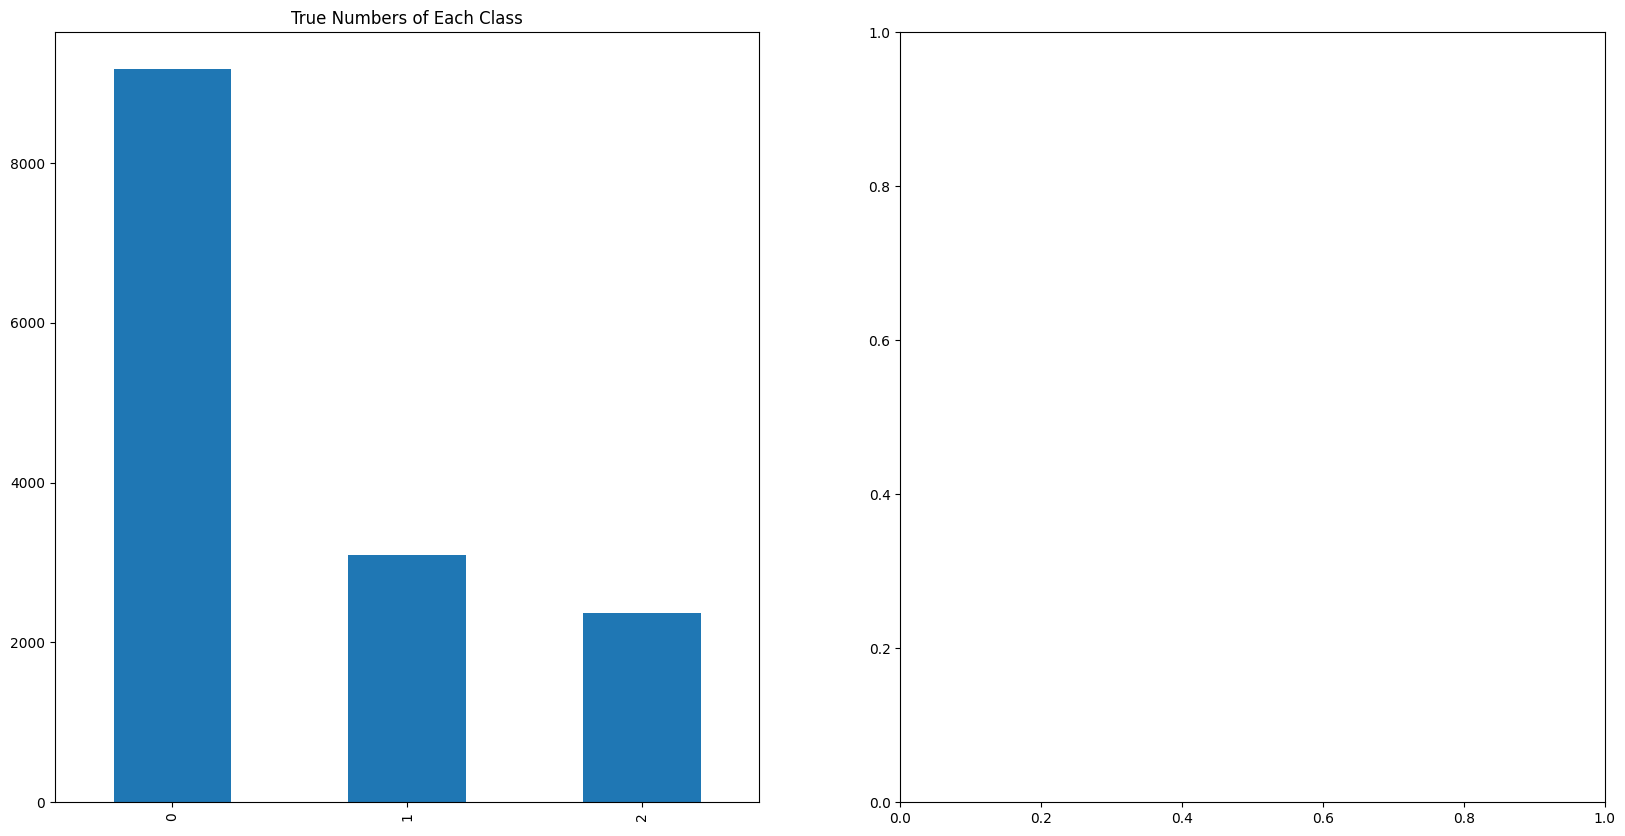

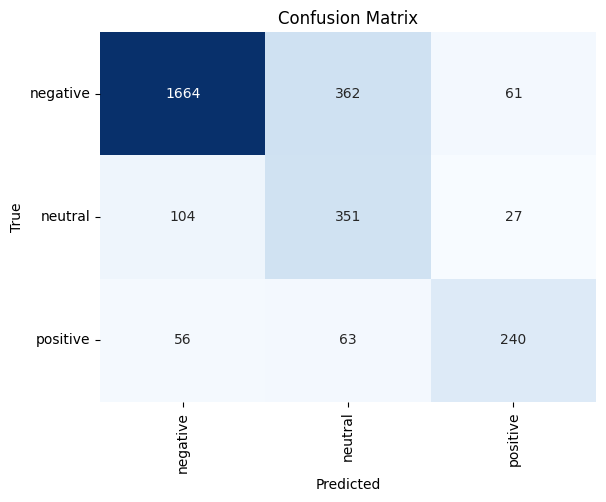

In [66]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion Matrix")
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()
      
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
# Graph a bar plot of true values overall
df.airline_sentiment.value_counts().plot(kind='bar')
plt.title("True Numbers of Each Class")
plt.subplot(1, 2, 2)


# Get predictions and plot confusion matrix
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in valid_iterator:
        x, y = x.to(device), y.to(device)
        y_pred += torch.argmax(model(x), dim=1).cpu().numpy().tolist()
        
y_true = torch.argmax(y_test, dim=1).cpu().numpy()
plot_confusion_matrix(y_true, y_pred, ['negative', 'neutral', 'positive'])


## Airline Embeddings
Use embeddings trained with word2vec on this dataset.

Embedding Dimensions: 100
SentimentModel(
  (embedding): Embedding(5000, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:07,  1.15it/s]

Epoch 1/10
Train Loss 0.8826077889874985, Train Acc 0.6187670765027322
Val Loss 0.6788771541222282, Val Acc 0.7434329710144927
--------------------------------------------------


 20%|██        | 2/10 [00:01<00:07,  1.14it/s]

Epoch 2/10
Train Loss 0.6925304410724692, Train Acc 0.7237875683060109
Val Loss 0.5413706092082936, Val Acc 0.785552536231884
--------------------------------------------------


 30%|███       | 3/10 [00:02<00:06,  1.16it/s]

Epoch 3/10
Train Loss 0.5389413860489111, Train Acc 0.7990949453551912
Val Loss 0.487294760087262, Val Acc 0.8181612318840579
--------------------------------------------------


 40%|████      | 4/10 [00:03<00:05,  1.17it/s]

Epoch 4/10
Train Loss 0.4452976740367426, Train Acc 0.8431523224043715
Val Loss 0.48307490672754205, Val Acc 0.8171422101449275
--------------------------------------------------


 50%|█████     | 5/10 [00:04<00:04,  1.19it/s]

Epoch 5/10
Train Loss 0.3842663428252512, Train Acc 0.8666325136612022
Val Loss 0.48410512183023535, Val Acc 0.8247282608695652
--------------------------------------------------


 60%|██████    | 6/10 [00:05<00:03,  1.20it/s]

Epoch 6/10
Train Loss 0.33738173845687197, Train Acc 0.8867827868852459
Val Loss 0.5066940651639648, Val Acc 0.8175951086956522
--------------------------------------------------


 70%|███████   | 7/10 [00:05<00:02,  1.19it/s]

Epoch 7/10
Train Loss 0.3058224028088356, Train Acc 0.8998463114754098
Val Loss 0.5783068207295045, Val Acc 0.7923460144927535
--------------------------------------------------


 80%|████████  | 8/10 [00:06<00:01,  1.18it/s]

Epoch 8/10
Train Loss 0.2791982408755464, Train Acc 0.9082137978142076
Val Loss 0.6094949964595877, Val Acc 0.7790987318840579
--------------------------------------------------


 90%|█████████ | 9/10 [00:07<00:00,  1.18it/s]

Epoch 9/10
Train Loss 0.24852520249824706, Train Acc 0.9195696721311475
Val Loss 0.6024487666461779, Val Acc 0.7978940217391305
--------------------------------------------------


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

Epoch 10/10
Train Loss 0.22167308846376632, Train Acc 0.9312670765027322
Val Loss 0.6105958518126736, Val Acc 0.8037817028985508
--------------------------------------------------


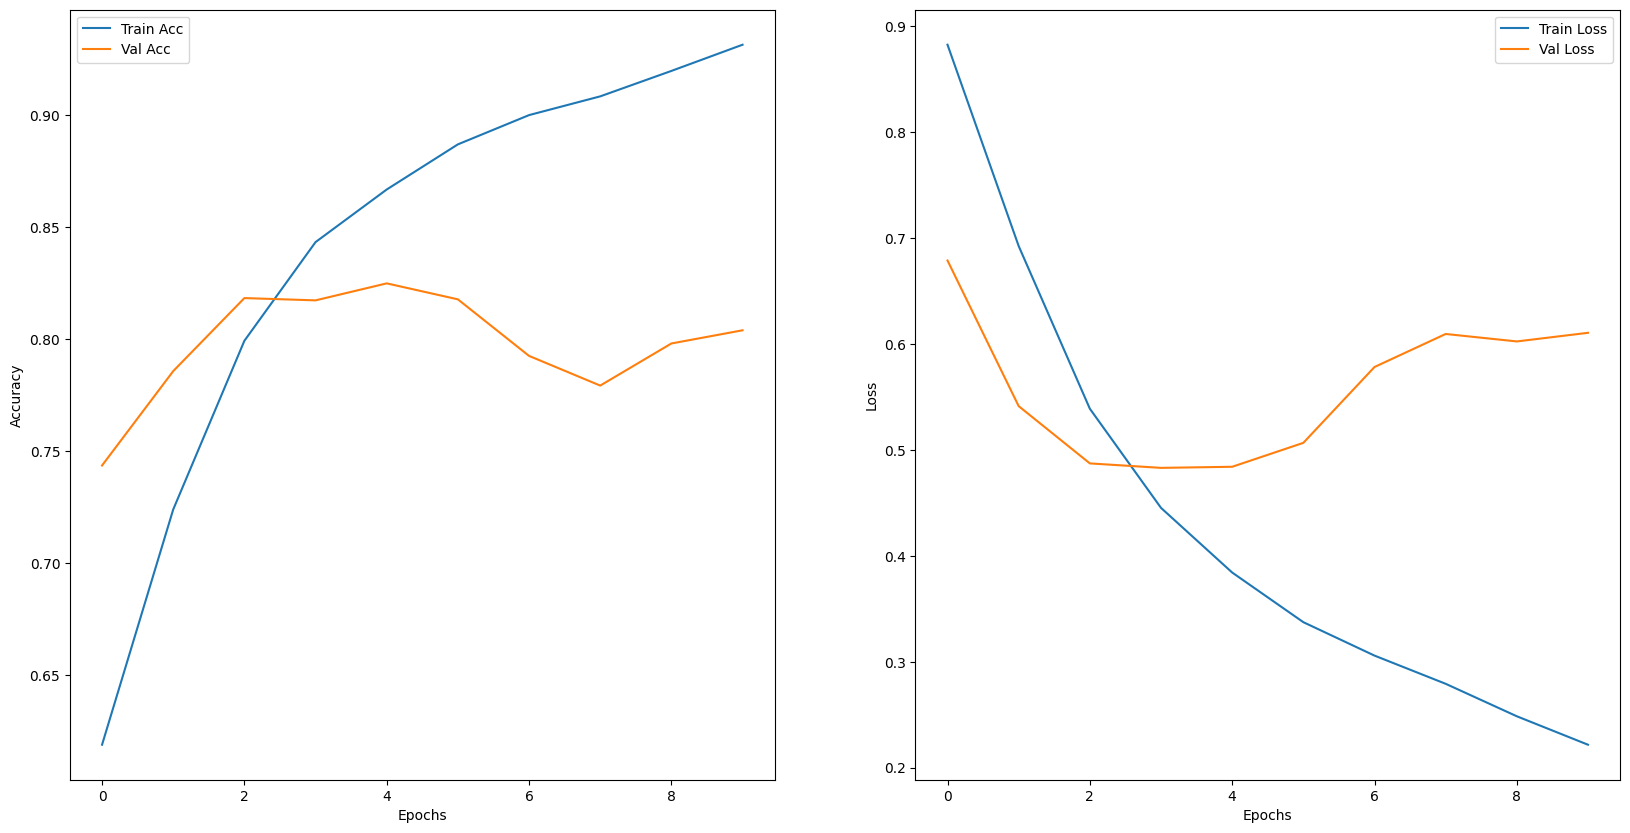

In [67]:
from gensim.models import Word2Vec
w2v = Word2Vec.load("../out/airlinetweets_word2vec_100.model") 

vocab_size = len(my_vocab)
embedding_dimensions = w2v.vector_size
print("Embedding Dimensions:", embedding_dimensions)

# Initialize the embeddings matrix
embeddings = np.zeros((vocab_size, embedding_dimensions))
for i, word in enumerate(my_vocab.get_itos()):
    if word in w2v.wv:
        embeddings[i] = w2v.wv[word]
    else:
        embeddings[i] = np.random.normal(scale=0.6, size=(embedding_dimensions, ))
        

N_EPOCHS = 10
best_valid_loss = float('inf')
criterion = nn.CrossEntropyLoss()

model = SentimentModel(
    vocab_size=len(my_vocab), 
    embedding_dim=100, 
    hidden_dim=32, 
    output_dim=3, 
    n_layers=2, 
    bidirectional=True, 
    dropout=0.5,
    pretrained_embeddings=torch.tensor(embeddings).float()
)
print(model)

train_history = { "train_acc": [], "val_acc": [], "train_loss": [], "val_loss": [] }
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_iterator = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=64)

count = 1
for epoch in tqdm(range(N_EPOCHS)):
    train_step_loss, train_step_acc = train_step(model, train_iterator, optimizer, criterion, device)
    valid_step_loss, valid_step_acc = eval_step(model, valid_iterator, criterion, device)
    
    print(f"Epoch {count}/{N_EPOCHS}")
    print(f"Train Loss {train_step_loss}, Train Acc {train_step_acc}")
    print(f"Val Loss {valid_step_loss}, Val Acc {valid_step_acc}")
    count += 1
    print("-" * 50)
    train_history["train_acc"].append(train_step_acc)
    train_history["val_acc"].append(valid_step_acc)
    train_history["train_loss"].append(train_step_loss)
    train_history["val_loss"].append(valid_step_loss)

plot_history(train_history)
all_history["airlinetweets_word2vec"] = train_history
    

## Text8 Embeddings

Embedding Dimensions: 100
SentimentModel(
  (embedding): Embedding(5000, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


 10%|█         | 1/10 [00:00<00:07,  1.26it/s]

Epoch 1/10
Train Loss 0.8620316637018339, Train Acc 0.6244877049180327
Val Loss 0.6338424365157667, Val Acc 0.7600769927536232
--------------------------------------------------


 20%|██        | 2/10 [00:01<00:06,  1.24it/s]

Epoch 2/10
Train Loss 0.675305320509796, Train Acc 0.731386612021858
Val Loss 0.5374648104543271, Val Acc 0.801064311594203
--------------------------------------------------


 30%|███       | 3/10 [00:02<00:05,  1.21it/s]

Epoch 3/10
Train Loss 0.5514891735517262, Train Acc 0.7929474043715847
Val Loss 0.500782222851463, Val Acc 0.8108016304347826
--------------------------------------------------


 40%|████      | 4/10 [00:03<00:05,  1.15it/s]

Epoch 4/10
Train Loss 0.4774924596476425, Train Acc 0.8235997267759563
Val Loss 0.488157721641271, Val Acc 0.8206521739130435
--------------------------------------------------


 50%|█████     | 5/10 [00:04<00:04,  1.10it/s]

Epoch 5/10
Train Loss 0.4198436729732107, Train Acc 0.8474214480874317
Val Loss 0.48995961054511694, Val Acc 0.8228034420289856
--------------------------------------------------


 60%|██████    | 6/10 [00:05<00:03,  1.10it/s]

Epoch 6/10
Train Loss 0.38560318087782364, Train Acc 0.8628756830601093
Val Loss 0.5104960080074228, Val Acc 0.8071784420289856
--------------------------------------------------


 70%|███████   | 7/10 [00:06<00:02,  1.14it/s]

Epoch 7/10
Train Loss 0.3389156848558637, Train Acc 0.8788422131147541
Val Loss 0.5134443167759024, Val Acc 0.8163496376811594
--------------------------------------------------


 80%|████████  | 8/10 [00:06<00:01,  1.14it/s]

Epoch 8/10
Train Loss 0.30623867244668346, Train Acc 0.8954064207650273
Val Loss 0.5746959532084672, Val Acc 0.7978940217391305
--------------------------------------------------


 90%|█████████ | 9/10 [00:07<00:00,  1.17it/s]

Epoch 9/10
Train Loss 0.27924405009857295, Train Acc 0.9090676229508197
Val Loss 0.6033237816199012, Val Acc 0.7909873188405797
--------------------------------------------------


100%|██████████| 10/10 [00:08<00:00,  1.16it/s]

Epoch 10/10
Train Loss 0.2513524986844245, Train Acc 0.9175204918032787
Val Loss 0.6308688352937284, Val Acc 0.7835144927536232
--------------------------------------------------


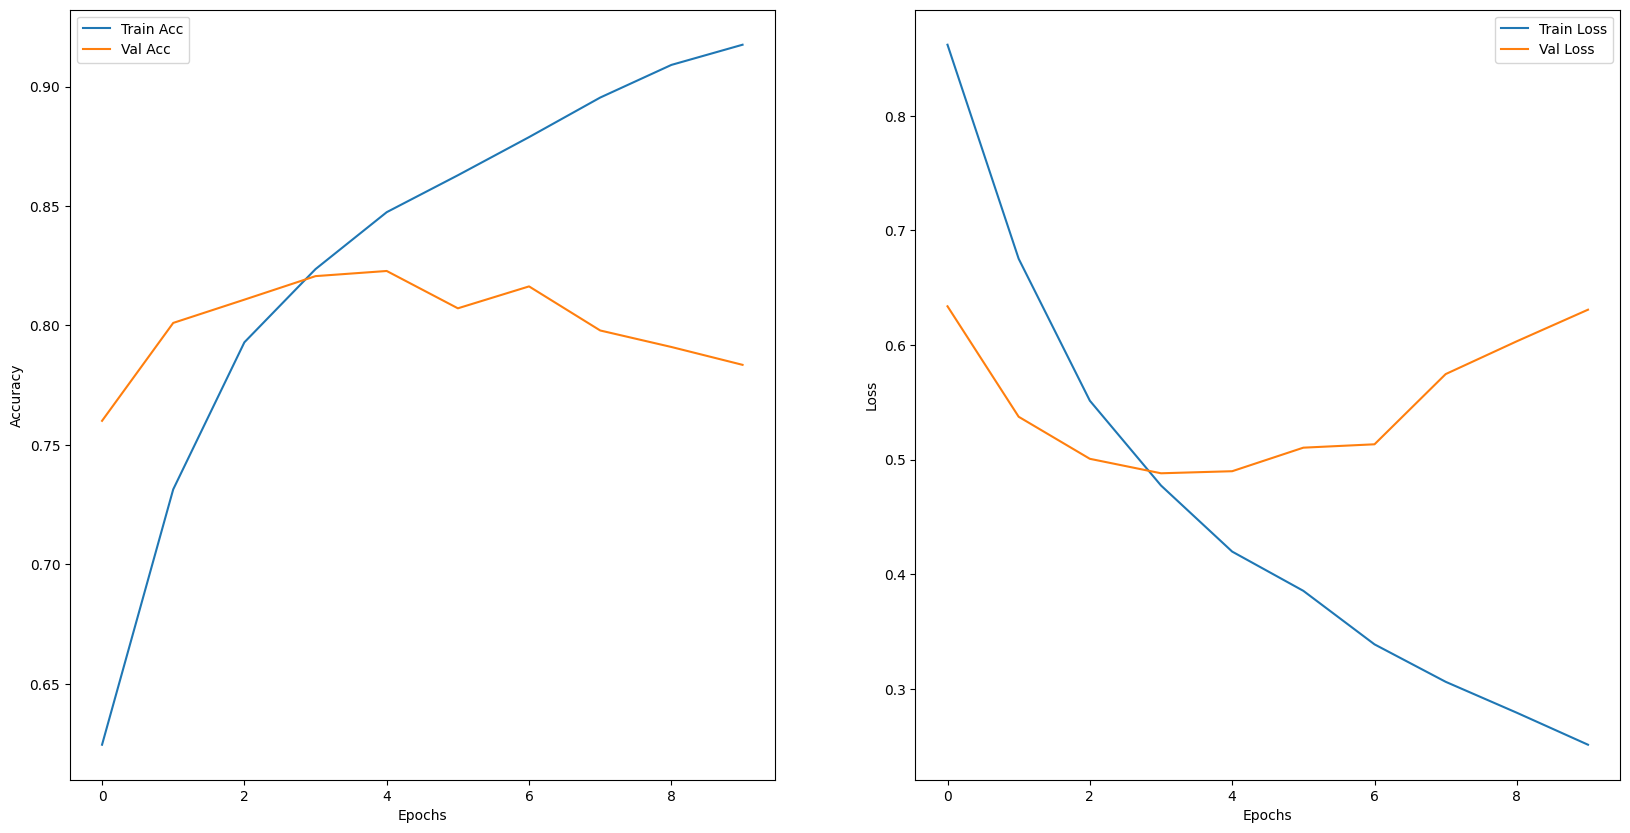

In [68]:
# Load the trained embeddings on text8
from gensim.models import Word2Vec
w2v = Word2Vec.load("../out/text8_word2vec_100.model") 

vocab_size = len(my_vocab)
embedding_dimensions = w2v.vector_size
print("Embedding Dimensions:", embedding_dimensions)

# Initialize the embeddings matrix
embeddings = np.zeros((vocab_size, embedding_dimensions))
for i, word in enumerate(my_vocab.get_itos()):
    if word in w2v.wv:
        embeddings[i] = w2v.wv[word]
    else:
        embeddings[i] = np.random.normal(scale=0.6, size=(embedding_dimensions, ))
        

N_EPOCHS = 10
best_valid_loss = float('inf')
criterion = nn.CrossEntropyLoss()

model = SentimentModel(
    vocab_size=len(my_vocab), 
    embedding_dim=100, 
    hidden_dim=32, 
    output_dim=3, 
    n_layers=2, 
    bidirectional=True, 
    dropout=0.5,
    pretrained_embeddings=torch.tensor(embeddings).float()
)
print(model)

train_history = { "train_acc": [], "val_acc": [], "train_loss": [], "val_loss": [] }
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_iterator = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=64)

count = 1
for epoch in tqdm(range(N_EPOCHS)):
    train_step_loss, train_step_acc = train_step(model, train_iterator, optimizer, criterion, device)
    valid_step_loss, valid_step_acc = eval_step(model, valid_iterator, criterion, device)
    
    print(f"Epoch {count}/{N_EPOCHS}")
    print(f"Train Loss {train_step_loss}, Train Acc {train_step_acc}")
    print(f"Val Loss {valid_step_loss}, Val Acc {valid_step_acc}")
    count += 1
    print("-" * 50)
    train_history["train_acc"].append(train_step_acc)
    train_history["val_acc"].append(valid_step_acc)
    train_history["train_loss"].append(train_step_loss)
    train_history["val_loss"].append(valid_step_loss)

plot_history(train_history)
all_history["text8_word2vec"] = train_history

Not only do we obtain a higher accuracy, but the model converges much faster.

## Google News Vector
Let's use the google news vector embeddings


In [69]:
googlenews_kv: KeyedVectors = KeyedVectors.load_word2vec_format(
    '../data/GoogleNews-vectors-negative300.bin', binary=True)

Embedding Dimensions: 300
SentimentModel(
  (embedding): Embedding(5000, 300)
  (lstm): LSTM(300, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:09,  1.02s/it]

Epoch 1/10
Train Loss 0.8353622684387562, Train Acc 0.6435280054644809
Val Loss 0.594321292379628, Val Acc 0.769927536231884
--------------------------------------------------


 20%|██        | 2/10 [00:01<00:07,  1.10it/s]

Epoch 2/10
Train Loss 0.5819695430700896, Train Acc 0.7787739071038251
Val Loss 0.4706051560199779, Val Acc 0.8113677536231884
--------------------------------------------------


 30%|███       | 3/10 [00:02<00:06,  1.13it/s]

Epoch 3/10
Train Loss 0.4286744286372362, Train Acc 0.844176912568306
Val Loss 0.48281912408445193, Val Acc 0.8205389492753623
--------------------------------------------------


 40%|████      | 4/10 [00:03<00:05,  1.17it/s]

Epoch 4/10
Train Loss 0.3369595409253907, Train Acc 0.886441256830601
Val Loss 0.5101855202861454, Val Acc 0.8103487318840579
--------------------------------------------------


 50%|█████     | 5/10 [00:04<00:04,  1.18it/s]

Epoch 5/10
Train Loss 0.27947340531101644, Train Acc 0.9120560109289617
Val Loss 0.5802507277416147, Val Acc 0.7915534420289856
--------------------------------------------------


 60%|██████    | 6/10 [00:05<00:03,  1.19it/s]

Epoch 6/10
Train Loss 0.2395406722757823, Train Acc 0.9287056010928961
Val Loss 0.6282390569863112, Val Acc 0.7835144927536232
--------------------------------------------------


 70%|███████   | 7/10 [00:06<00:02,  1.18it/s]

Epoch 7/10
Train Loss 0.20562872728281986, Train Acc 0.9400614754098361
Val Loss 0.6174187064170837, Val Acc 0.8008378623188406
--------------------------------------------------


 80%|████████  | 8/10 [00:06<00:01,  1.19it/s]

Epoch 8/10
Train Loss 0.18777983678413218, Train Acc 0.9452698087431693
Val Loss 0.6819805483455244, Val Acc 0.7892889492753623
--------------------------------------------------


 90%|█████████ | 9/10 [00:07<00:00,  1.20it/s]

Epoch 9/10
Train Loss 0.16427356639846427, Train Acc 0.9534665300546448
Val Loss 0.7076411117678103, Val Acc 0.8007246376811594
--------------------------------------------------


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]

Epoch 10/10
Train Loss 0.14471130357556494, Train Acc 0.9592725409836066
Val Loss 0.7036596620860307, Val Acc 0.8058197463768116
--------------------------------------------------


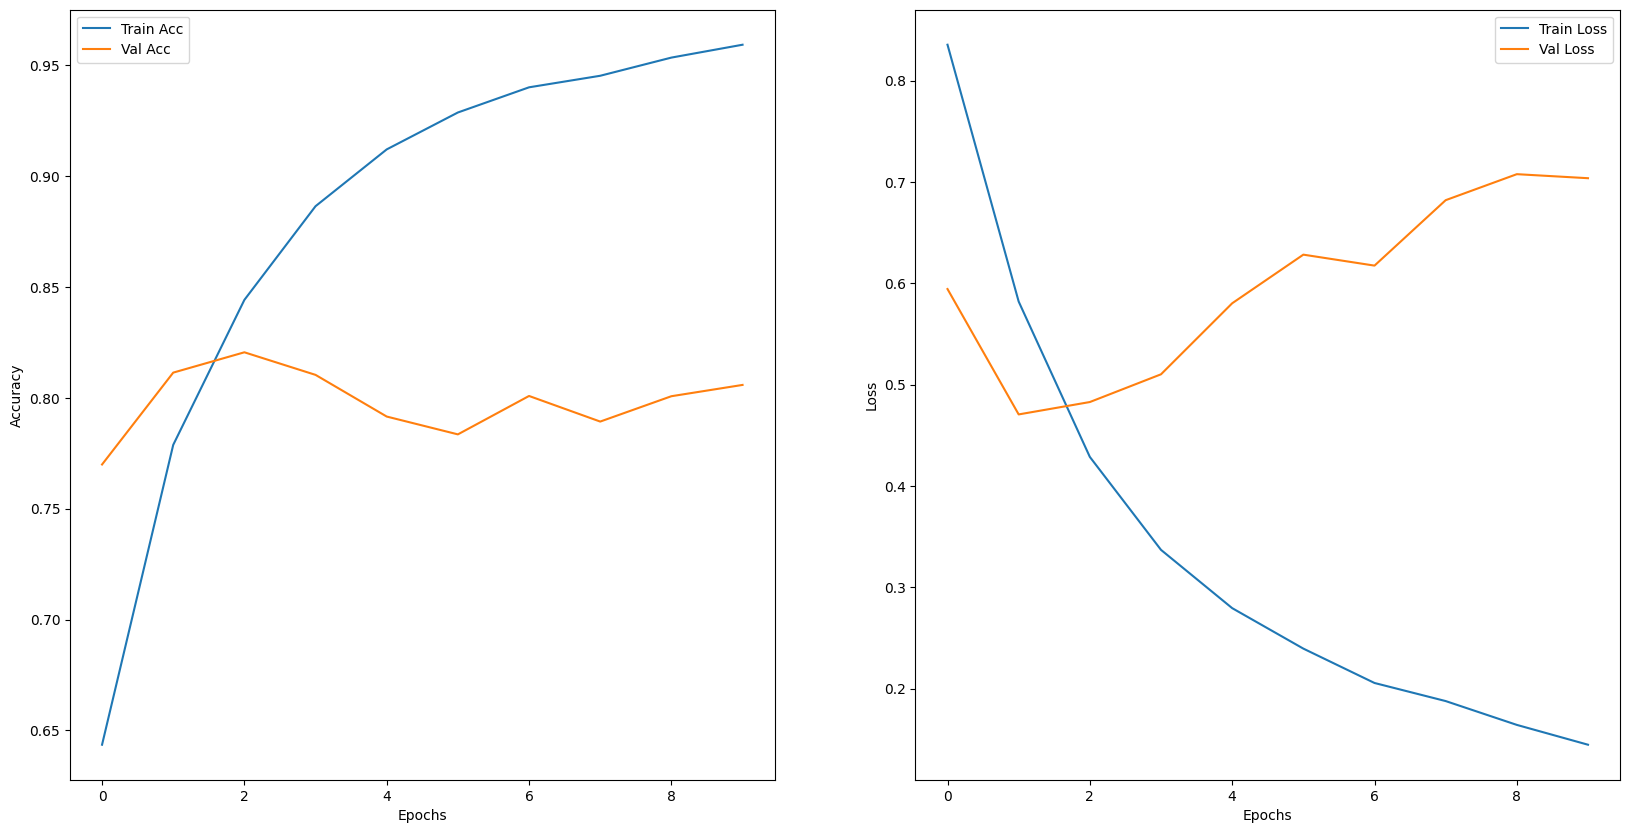

In [70]:
vocab_size = len(my_vocab)
embedding_dimensions = googlenews_kv.vector_size
print("Embedding Dimensions:", embedding_dimensions)

# Initialize the embeddings matrix
embeddings = np.zeros((vocab_size, embedding_dimensions))
for i, word in enumerate(my_vocab.get_itos()):
    if word in googlenews_kv:
        embeddings[i] = googlenews_kv[word]
    else:
        embeddings[i] = np.random.normal(scale=0.6, size=(embedding_dimensions, ))
        
N_EPOCHS = 10
best_valid_loss = float('inf')
criterion = nn.CrossEntropyLoss()

model = SentimentModel(
    vocab_size=len(my_vocab), 
    embedding_dim=embedding_dimensions, 
    hidden_dim=32, 
    output_dim=3, 
    n_layers=2, 
    bidirectional=True, 
    dropout=0.5,
    pretrained_embeddings=torch.tensor(embeddings).float()
)
print(model)

train_history = { "train_acc": [], "val_acc": [], "train_loss": [], "val_loss": [] }
model = model.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_iterator = torch.utils.data.DataLoader(train_data, batch_size=64)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=64)

count = 1
for epoch in tqdm(range(N_EPOCHS)):
    train_step_loss, train_step_acc = train_step(model, train_iterator, optimizer, criterion, device)
    valid_step_loss, valid_step_acc = eval_step(model, valid_iterator, criterion, device)
    
    print(f"Epoch {count}/{N_EPOCHS}")
    print(f"Train Loss {train_step_loss}, Train Acc {train_step_acc}")
    print(f"Val Loss {valid_step_loss}, Val Acc {valid_step_acc}")
    count += 1
    print("-" * 50)
    train_history["train_acc"].append(train_step_acc)
    train_history["val_acc"].append(valid_step_acc)
    train_history["train_loss"].append(train_step_loss)
    train_history["val_loss"].append(valid_step_loss)

plot_history(train_history)
all_history["googlenews_word2vec"] = train_history

It seems that these embeddings are overfitting on the training dataset. Even though googlenewsvector embeddings were trained on a much bigger corpus. It did not perform as well as text8.

{'default': {'train_acc': [0.6239754098360656, 0.725068306010929, 0.7841530054644809, 0.8154030054644809, 0.8434084699453552, 0.8672301912568307, 0.8837943989071039, 0.898650956284153, 0.9144467213114754, 0.9276810109289617], 'val_acc': [0.759171195652174, 0.7494338768115942, 0.7956295289855073, 0.7804574275362318, 0.7728713768115942, 0.782608695652174, 0.7783061594202899, 0.7803442028985508, 0.7668704710144927, 0.770606884057971], 'train_loss': [0.8824930031442902, 0.6907909509262752, 0.5673002628355078, 0.49556767468244, 0.43224346739509717, 0.3818131662864503, 0.3338026564792206, 0.30490964462807596, 0.26244429986455725, 0.2345095696792902], 'val_loss': [0.6893355081910673, 0.5961506301942079, 0.5148037037123805, 0.5369177195041076, 0.5522883547388989, 0.5516632354777792, 0.5760706021733906, 0.5981042566506759, 0.630406379699707, 0.6510882280443026]}, 'airlinetweets_word2vec': {'train_acc': [0.6187670765027322, 0.7237875683060109, 0.7990949453551912, 0.8431523224043715, 0.8666325136

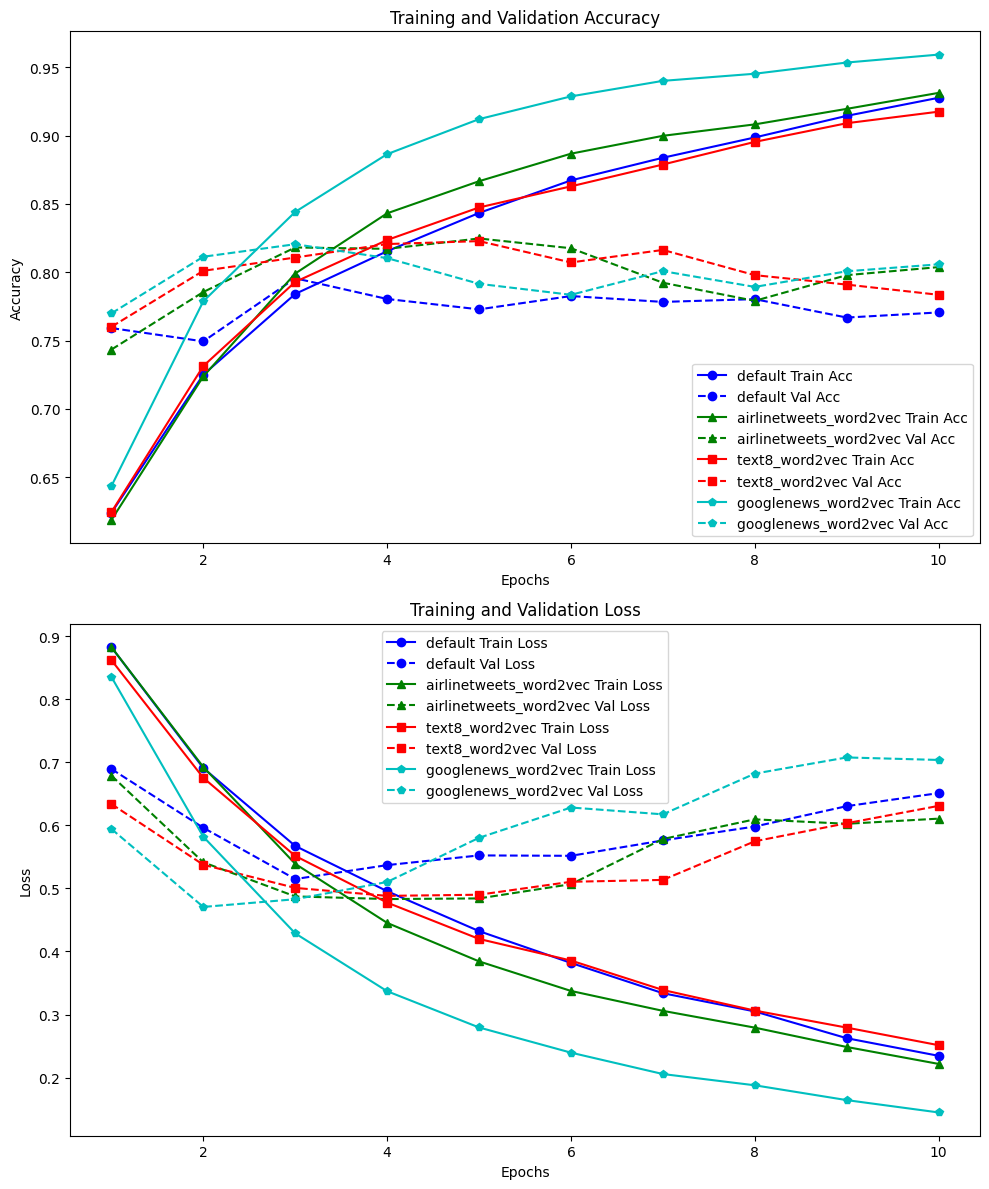

In [73]:
# Plot all_history
print(all_history)


# Creating a figure and subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))  # 2 rows for acc and loss, 1 column

# Plotting settings
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for different models
markers = ['o', '^', 's', 'p', '*', '+', 'x']  # Markers for different models

for idx, (key, metrics) in enumerate(all_history.items()):
    epochs = range(1, len(metrics['train_acc']) + 1)
    
    # Subplot for accuracy
    axs[0].plot(epochs, metrics['train_acc'], label=f'{key} Train Acc', marker=markers[idx % len(markers)], color=colors[idx % len(colors)])
    axs[0].plot(epochs, metrics['val_acc'], label=f'{key} Val Acc', linestyle='--', marker=markers[idx % len(markers)], color=colors[idx % len(colors)])
    
    # Subplot for loss
    axs[1].plot(epochs, metrics['train_loss'], label=f'{key} Train Loss', marker=markers[idx % len(markers)], color=colors[idx % len(colors)])
    axs[1].plot(epochs, metrics['val_loss'], label=f'{key} Val Loss', linestyle='--', marker=markers[idx % len(markers)], color=colors[idx % len(colors)])

# Setting labels and titles
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].legend()

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training and Validation Loss')
axs[1].legend()

plt.tight_layout()
plt.show()


We see that pretrained embeddings do help in performance. However, embeddings trained on bigger corpus (googlenews), has a tendency to overfit.